Shape Optimization
==================

In this tutorial, we will optimize a triangle mesh to match a target shape, based on a set of reference renderings.

Gradients with regards to vertex positions are typically extremely sparse, since only vertices located on visibility discontinuities receive a contribution. As a consequence, naively optimizing a triangle mesh generally results in horrible, tangled meshes.

To avoid this, we will use the method from the paper "Large Steps in Inverse Rendering of Geometry" <cite data-cite="Nicolet2021">[Nicolet et al. 2021]</cite>. This method uses Laplacian preconditioning as an approximation of a second-order step.

## Setup

As always, let's import `drjit` and `mitsuba` and set a differentiation-aware variant.

In [34]:
import mitsuba as mi
mi.set_variant("cuda_ad_rgb")
import drjit as dr
import numpy as np
import scipy.sparse as sp

import matplotlib.pyplot as plt

from ipywidgets import interact


Let's compute the Laplacian with Numpy:

In [35]:
def compute_laplacian(n_verts, faces, lambda_):

    # Neighbor indices
    ii = faces[:, [1, 2, 0]].flatten()
    jj = faces[:, [2, 0, 1]].flatten()
    adj = np.unique(np.stack([np.concatenate([ii, jj]), np.concatenate([jj, ii])], axis=0), axis=1)
    adj_values = np.ones(adj.shape[1], dtype=np.float64) * lambda_

    # Diagonal indices, duplicated as many times as the connectivity of each index
    diag_idx = np.stack((adj[0], adj[0]), axis=0)

    diag = np.stack((np.arange(n_verts), np.arange(n_verts)), axis=0)

    # Build the sparse matrix
    idx = np.concatenate((adj, diag_idx, diag), axis=1)
    values = np.concatenate((-adj_values, adj_values, np.ones(n_verts)))

    return sp.csc_matrix((values, idx))

In [36]:
def to_differential(verts, faces, lambda_):
    L_csc = compute_laplacian(len(verts)//3, faces.numpy().reshape((-1,3)), lambda_)
    return mi.TensorXf((L_csc @ verts.numpy().reshape((-1,3))))

In order to use the "Large Steps" method, we need a differentiable solve function. We implement it as a Dr.JIT custom op:

In [37]:
from cholespy import CholeskySolverF, MatrixType

class CholeskySolve(dr.CustomOp):

    def eval(self, solver, u):
        self.solver = solver
        x = dr.empty(dr.cuda.TensorXf, shape=u.shape)
        solver.solve(u, x)
        return mi.TensorXf(x)

    def forward(self):
        x = dr.empty(mi.TensorXf, shape=self.grad_in('u').shape)
        self.solver.solve(self.grad_in('u'), x)
        self.set_grad_out(x)

    def backward(self):
        x = dr.empty(dr.cuda.TensorXf, shape=self.grad_out().shape)
        self.solver.solve(self.grad_out(), x)
        self.set_grad_in('u', x)

    def name(self):
        return "Cholesky solve"

class CholeskySolver():
    def __init__(self, verts, faces, lambda_):
        n_verts = len(verts) // 3
        L_csc = compute_laplacian(n_verts, faces.numpy().reshape((-1,3)), lambda_)
        self.solver = CholeskySolverF(n_verts, mi.TensorXi(L_csc.indptr), mi.TensorXi(L_csc.indices), mi.TensorXd(L_csc.data), MatrixType.CSC)

    def solve(self, u):
        return dr.custom(CholeskySolve, self.solver, u)


Now let's load a scene to optimize:

In [49]:
res = 256

source_scene = mi.load_file("scenes/bunny/scene.xml", res=res, integrator="direct_reparam", mesh="source", brdf="flat")
target_scene = mi.load_file("scenes/bunny/scene.xml", res=res, integrator="direct_reparam", mesh="target", brdf="charuco")

# n_viewpoints = len(target_scene.sensors())
n_viewpoints = 4

We generate the reference renderings:

In [50]:
ref_imgs = []
for i in range(n_viewpoints):
	ref_imgs.append(mi.render(target_scene, spp=256, sensor=i))

In [51]:
@interact(i=(0,n_viewpoints-1))
def show_target(i):
	plt.imshow((ref_imgs[i].numpy()**(1/2.2)).clip(0,1))
	plt.axis('off')

interactive(children=(IntSlider(value=1, description='i', max=3), Output()), _dom_classes=('widget-interact',)…

## Optimization

Instead of optimizing the vertex coordinates, we first embed them as `u = (I +λL)x` and optimize those coordinates instead. In order for this to work, we use a modification of the `Adam` optimizer, that uses a uniform second moment for all parameters.

In [41]:
params = mi.traverse(source_scene)
lambda_ = 19

param_tex = "flat.brdf_0.reflectance.data"

solver = CholeskySolver(params['mesh-source.vertex_positions'], params['mesh-source.faces'], lambda_)
opt = mi.ad.Adam(lr=1e-1, uniform=True, mask_updates=True)

opt[param_tex] = params[param_tex]
opt['u'] = to_differential(params['mesh-source.vertex_positions'], params['mesh-source.faces'], lambda_)

Now let's run the optimization:

In [42]:
num_steps = 500
loss_hist = np.zeros(num_steps)
from tqdm import trange
for it in trange(num_steps):
    loss = mi.Float(0.0)


    for i in range(n_viewpoints):
        params['mesh-source.vertex_positions'] = solver.solve(opt['u']).array
        params.update()
        img = mi.render(source_scene, params, sensor=i, seed=it*n_viewpoints + i, spp=16)

        # L1 Loss
        img_loss = dr.mean(dr.abs(img - ref_imgs[i]))
        loss += img_loss

        loss_hist[it] += img_loss[0]

        dr.backward(img_loss)
        opt.step()
    
    print(f"Iteration {1+it:03d}/{num_steps}: Loss = {img_loss[0]:6f}", end='\r')


100%|██████████| 500/500 [11:23<00:00,  1.37s/it]


## Results

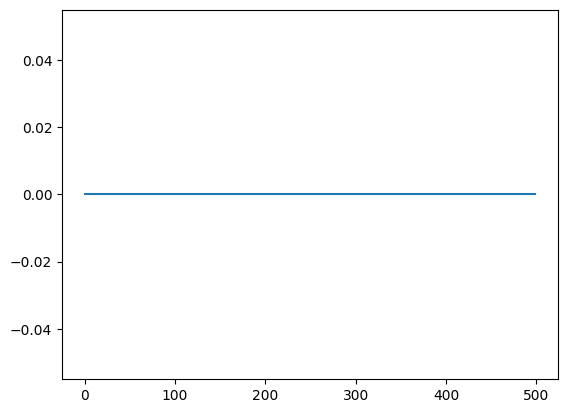

In [11]:
plt.plot(loss_hist)

In [52]:
params['mesh-source.vertex_positions'] = solver.solve(opt['u']).array
params.update()
final_imgs = []
for i in range(n_viewpoints):
	final_imgs.append(mi.render(source_scene, spp=64, sensor=i))

In [53]:
@interact(i=(0,n_viewpoints-1))
def show_final(i):
	plt.imshow((final_imgs[i].numpy()**(1/2.2)).clip(0,1))
	plt.axis('off')

interactive(children=(IntSlider(value=1, description='i', max=3), Output()), _dom_classes=('widget-interact',)…

In [ ]:
import meshplot

In [ ]:
meshplot.plot(params['mesh-source.vertex_positions'].numpy().reshape((-1,3)),params['mesh-source.faces'].numpy().reshape((-1,3)))

/home/bnicolet/miniconda3/envs/graphics/lib/python3.10/site-packages/jupyter_client/session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.3538852…